In [22]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import matplotlib as mpl
from matplotlib.cbook import boxplot_stats
from cycler import cycler
import itertools
import os
#import tikzplotlib

In [23]:
MAXSAMPLES=3000
def resample(data, count=MAXSAMPLES):
    return data
    count = min(count, len(data))
    datasize = len(data)
    indices = [(i * (datasize-1)) // (count - 1) for i in range(count)]
    return data.iloc[indices]
def maxbound(instance):
    bounds = {'Texas': 2000, 'Western': 10024, 'Eastern': 70047, 'USA': 82071}
    b = 1e9
    for name, bound in bounds.items():
        if name in instance:
            b = bound
    return b

pd.DataFrame({})

for path in ['ours', 'smith', 'milp']:
    dirent = list(os.walk(f'bounds-{path}'))[0]
    for instance in dirent[2]:
        if instance.endswith('-bounds.csv'):
            dta = pd.read_csv(f'{dirent[0]}/{instance}', comment='#')
            os.makedirs(f'figures/{dirent[0]}', exist_ok=True)
            dta['gap'] = (dta['upper'] - dta['lower']) / dta['upper']
            dta['t'] = dta['t'] / 1000
            dta.drop_duplicates(subset=['lower', 'upper'], keep='first')
            dta['upper'].where(dta['upper'] < 1000000000, maxbound(instance), inplace=True)
            dta['extra'].where(dta['extra'] < 1000000000, float('nan'), inplace=True)
            #dta = resample(dta)
            dta.to_csv(f'figures/{dirent[0]}/{instance}', index=False)

In [24]:
name = 'case9241pegase'
ours = pd.read_csv(f'figures/bounds-ours/{name}-0-bounds.csv',comment='#')
theirs = pd.read_csv(f'figures/bounds-smith/{name}-0-bounds.csv', comment='#')
gurobi = pd.read_csv(f'figures/bounds-milp/{name}-0-bounds.csv', comment='#')

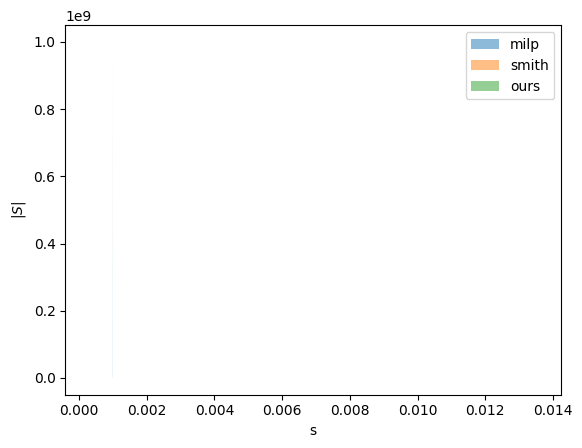

In [25]:
#plt.xscale('log')
for dta,name in [(gurobi,'milp'),(theirs,'smith'), (ours[:-2],'ours')]:#
    plt.fill_between(dta['t']/1000000, dta['lower'], dta['upper'], alpha=0.5,label=name)
plt.legend()
plt.xlabel('s')
plt.ylabel('$|S|$')
plt.show();


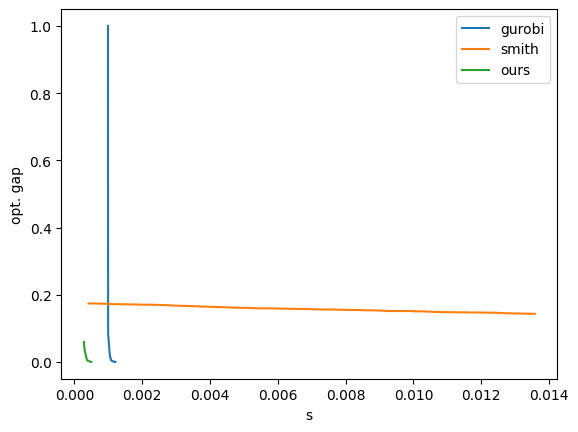

In [26]:
#plt.yscale('log')
for dta,name in [(gurobi,'gurobi'),(theirs,'smith'), (ours[1:],'ours')]:#
    plt.plot(dta['t']/1000000, dta['gap'], alpha=1,label=name)
plt.legend()
plt.xlabel('s')
plt.ylabel('opt. gap')
plt.show();


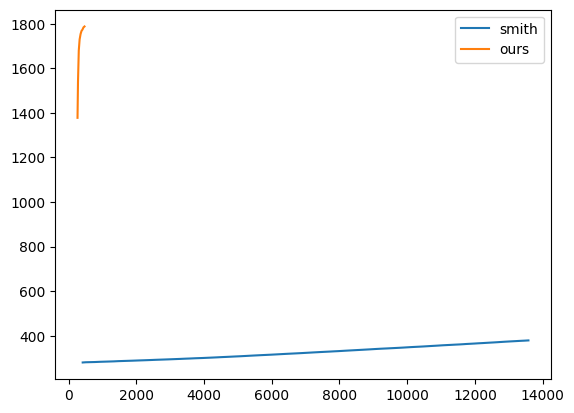

In [27]:
for dta,name in [(theirs,'smith'), (ours[:-2],'ours')]:
    dta = dta[dta['extra'] > 0]
    plt.plot(dta['t'],dta['extra'],label=name)
plt.legend()
plt.show();

In [28]:
cmap = mpl.colormaps['Dark2']
#colorcycle = cycler(color=[cmap.colors[i] for i in range(10)])
formats = pd.DataFrame(dict(\
    name='ours smith milp'.split(),
    color=[cmap.colors[i] for i in range(3)],
    hatch=['////', '...', '\\\\\\\\']
)).set_index('name').T
formats

name                                                ours   
color  (0.10588235294117647, 0.6196078431372549, 0.46...  \
hatch                                               ////   

name                                               smith   
color  (0.8509803921568627, 0.37254901960784315, 0.00...  \
hatch                                                ...   

name                                                milp  
color  (0.4588235294117647, 0.4392156862745098, 0.701...  
hatch                                               \\\\

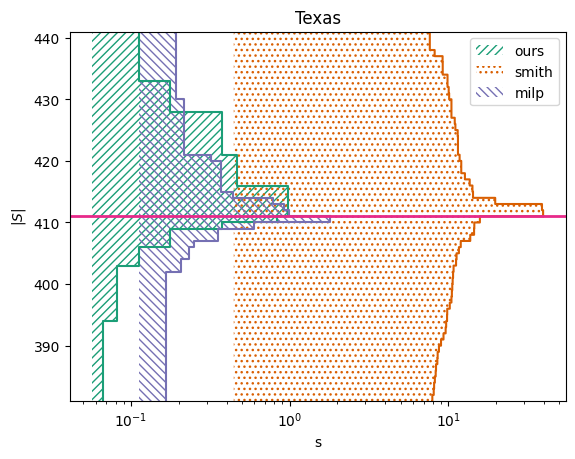

xmin=0.0411112282015524,xmax=54.7549980628163,ymin=381.0,ymax=441.0,
\addplot graphics[xmin=0.0411112282015524, xmax=54.7549980628163, ymin=381.0, ymax=441.0] {figures/evaluation/bounds-gap/bounds-Texas.pdf};
x: (0.0411112282015524, 54.7549980628163) y: (381.0, 441.0)
                     t  lower  upper   extra
Texas ours     981.109  411.0  411.0   838.0
      smith  39482.324  411.0  411.0   659.0
      milp    1806.497  411.0  411.0  4053.0
0.0 0.0


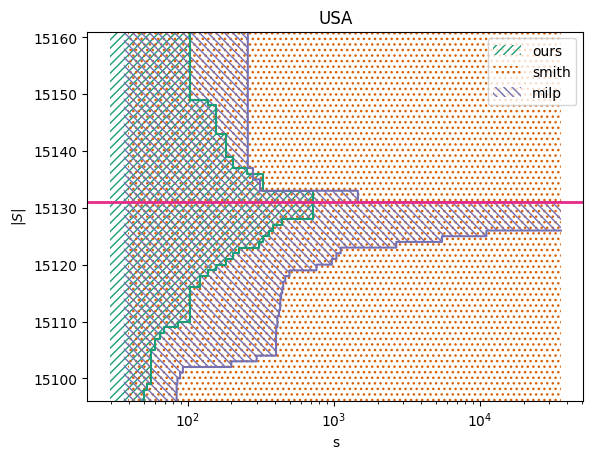

xmin=20.61432111982069,xmax=51419.59945287649,ymin=15096.0,ymax=15161.0,
\addplot graphics[xmin=20.61432111982069, xmax=51419.59945287649, ymin=15096.0, ymax=15161.0] {figures/evaluation/bounds-gap/bounds-USA.pdf};
x: (20.61432111982069, 51419.59945287649) y: (15096.0, 15161.0)
                      t    lower    upper      extra
USA ours   7.286201e+05  15131.0  15131.0    30357.0
    smith  3.603100e+07  14124.0  15993.0    16391.0
    milp   3.603474e+07  15126.0  15131.0  1223639.0
0.0 51.0


In [29]:
def duplicate_all(xs):
    return list(itertools.chain.from_iterable([v,v] for v in xs))

for name in 'Texas USA'.split():# Western Eastern
    #plt.xscale('log')
    xmin,xmax = float('inf'), 0
    results = dict()
    fig, ax = plt.subplots(1,1)
    ax.set_xscale('log')
    for path in ['ours', 'smith', 'milp']:
        color, pattern = formats[path]
        dta = pd.read_csv(f'figures/bounds-{path}/psd-{name}-0-bounds.csv',comment='#')
        t, lower, upper = dta['t']/1000, dta['lower'], dta['upper']
        t = duplicate_all(t)[1:]
        lower = duplicate_all(lower)[:-1]
        upper = duplicate_all(upper)[:-1]
        ax.fill_between(t, lower, upper,fc=(0,0,0,0),label=path, hatch=pattern, ec=color, lw=0,zorder=0)
        ax.plot(t, lower, color=color)
        ax.plot(t, upper, color=color)
        xmax=max(dta['t'].max(), xmax)
        xmin=min(dta['t'].min(), xmin)
        #ax.legend()
        ax.set_xlabel('s')
        ax.set_ylabel('$|S|$')
        dta['upper'] *= -1
        minmax = dta[['t', 'lower', 'upper', 'extra']].max()
        dta['upper'] *= -1
        minmax['upper'] *= -1
        results[(name, path)] = minmax
        #print(name, path, *dta[['t', 'lower', 'upper', 'extra']].iloc[-1])
        ax.set_ylim(bottom=minmax['lower']-30,top=minmax['upper']+30)
    ax.set_title(name)
    restbl = pd.DataFrame(results).T
    ax.axhline(restbl['lower'].max(), c=cmap.colors[3], ls='-',lw=2.0)
    #plt.axhline(restbl['upper'].min(), c='r', ls=':')
    #plt.show()
    extent = ax.get_window_extent().transformed(fig.dpi_scale_trans.inverted())
    ax.axis('off')
    os.makedirs(f'figures/bounds-gap/', exist_ok=True)
    plt.savefig(f'figures/bounds-gap/bounds-{name}.pdf', format='pdf',bbox_inches=extent)
    plt.axis('on')
    plt.legend()
    plt.show()
    xmin, xmax, ymin, ymax = np.array([*ax.get_xlim(), *ax.get_ylim()])
    print(f'xmin={xmin},xmax={xmax},ymin={ymin},ymax={ymax},')
    print(f'\\addplot graphics[xmin={xmin}, xmax={xmax}, ymin={ymin}, ymax={ymax}] {{figures/evaluation/bounds-gap/bounds-{name}.pdf}};')
    print('x:', ax.get_xlim(), 'y:', ax.get_ylim())
    print(pd.DataFrame(results).T)
    print(xmin // 1000, xmax // 1000)
    
#lt.show();


In [30]:

for name in 'Texas USA'.split():# Western Eastern
    #plt.xscale('log')
    xmin,xmax = float('inf'), 0
    results = dict()
    fig, ax = plt.subplots(1,1)
    print(fig.get_size_inches())
    fig.set_size_inches(7, 2)
    ax.set_xscale('log')
    ax.set_ylim(bottom=0.0, top=0.4)
    for path in ['ours', 'smith', 'milp']:
        color, pattern = formats[path]
        dta = pd.read_csv(f'figures/bounds-{path}/psd-{name}-0-bounds.csv',comment='#')
        ax.plot(dta['t']/1000, dta['gap'], color=color, label=f'{path}')
        xmax=max(dta['t'].max(), xmax)
        xmin=min(dta['t'].min(), xmin)
        #ax.legend()
        ax.set_xlabel('s')
        ax.set_ylabel('$|S|$')
        dta['upper'] *= -1
        minmax = dta[['t', 'lower', 'upper', 'extra']].max()
        #print(name, path, *dta[['t', 'lower', 'upper', 'extra']].iloc[-1])
        #ax.set_ylim(bottom=minmax['lower']-30,top=minmax['upper']+30)
    ax.set_title(name)
    #plt.axhline(restbl['upper'].min(), c='r', ls=':')
    #plt.show()
    extent = ax.get_window_extent().transformed(fig.dpi_scale_trans.inverted())
    ax.axis('off')
    plt.savefig(f'figures/bounds-gap/gap-{name}.pdf', format='pdf',bbox_inches=extent)
    xmin, xmax, ymin, ymax = np.array([*ax.get_xlim(), *ax.get_ylim()])
    print(f'xmin={xmin},xmax={xmax},ymin={ymin},ymax={ymax},')
    print(f'\\addplot graphics[xmin={xmin}, xmax={xmax}, ymin={ymin}, ymax={ymax}] {{figures/evaluation/bounds-gap/gap-{name}.pdf}};')
    plt.axis('on')
    plt.legend()
    plt.show()


[6.4 4.8]
xmin=0.0411112282015524,xmax=54.7549980628163,ymin=0.0,ymax=0.4,
\addplot graphics[xmin=0.0411112282015524, xmax=54.7549980628163, ymin=0.0, ymax=0.4] {figures/evaluation/bounds-gap/gap-Texas.pdf};


[6.4 4.8]
xmin=20.61432111982069,xmax=51419.59945287649,ymin=0.0,ymax=0.4,
\addplot graphics[xmin=20.61432111982069, xmax=51419.59945287649, ymin=0.0, ymax=0.4] {figures/evaluation/bounds-gap/gap-USA.pdf};


In [31]:
dta['lower'].iloc[-1]

15126

In [32]:
5.425731e+05

542573.1